In [1]:
%load_ext autoreload
%autoreload 2

import pydrake
import torch
import pyro
from pyro import poutine
import time
import matplotlib.pyplot as plt

import scene_generation.data.dataset_utils as dataset_utils
from scene_generation.models.planar_multi_object_multi_class_2_with_context import MultiObjectMultiClassModelWithContext

from collections import defaultdict
from torch.distributions import constraints
from pyro.infer import Trace_ELBO, SVI
from pyro.contrib.autoguide import AutoDelta, AutoDiagonalNormal, AutoMultivariateNormal, AutoGuideList
import datetime
from tensorboardX import SummaryWriter
from scene_generation.models.planar_multi_object_multi_class_2_with_context import MultiObjectMultiClassModelWithContext


In [2]:
import numpy as np
DATA_DIR_TRAIN = "/home/gizatt/projects/scene_generation/data/planar_tabletop/planar_tabletop_lines_scenes_train/"
DATA_DIR_TEST = "/home/gizatt/projects/scene_generation/data/planar_tabletop/planar_tabletop_lines_scenes_test/"

scenes_dataset_yaml = dataset_utils.ScenesDataset(DATA_DIR_TRAIN)
params_by_object_class = {}
for env_i in range(len(scenes_dataset_yaml)):
    env = scenes_dataset_yaml[env_i]
    for obj_i in range(env["n_objects"]):
        obj_yaml = env["obj_%04d" % obj_i]
        class_name = obj_yaml["class"]
        if class_name not in params_by_object_class.keys():
            params_by_object_class[class_name] = []
        params_by_object_class[class_name].append(obj_yaml["pose"] + obj_yaml["params"])

for object_name in params_by_object_class.keys():
    print object_name, ": "
    params = np.stack(params_by_object_class[object_name])
    print params.shape
    print "means: ", np.mean(params, axis=0)
    print "vars: ", np.std(params, axis=0)

2d_box : 
(4575, 5)
means:  [-0.00872321  0.00444568  3.14011483  0.19929218  0.20043479]
vars:  [0.26627299 0.2677912  1.81480141 0.05737896 0.05760085]
2d_sphere : 
(4392, 4)
means:  [2.75008170e-03 6.42149609e-03 3.15556028e+00 1.00161050e-01]
vars:  [0.26640715 0.26215936 1.80700842 0.0287064 ]


2987
{'obj_0002': {'color': [0.5, 0.25, 0.55021145355376, 1.0], 'pose': [-0.21182899831664853, 0.35949749631069405, 4.883779090319563], 'params': [0.10612887087061207, 0.2953846368191366], 'class': '2d_box', 'params_names': ['height', 'length']}, 'obj_0003': {'color': [0.25, 0.5, 0.5207177585959839, 1.0], 'pose': [-0.04650105577832774, 0.42181569071818914, 5.718999269729113], 'params': [0.11046974693469756], 'class': '2d_sphere', 'params_names': ['radius']}, 'obj_0000': {'color': [0.5, 0.25, 0.6764348497669448, 1.0], 'pose': [-0.3299549095160559, 0.11047309615615154, 2.91725937217298], 'params': [0.20465792637774805, 0.25782558926437305], 'class': '2d_box', 'params_names': ['height', 'length']}, 'obj_0001': {'color': [0.25, 0.5, 0.7044892067902758, 1.0], 'pose': [-0.37441384501120095, 0.33904603588154875, 0.9299097542675108], 'params': [0.10062637192932683], 'class': '2d_sphere', 'params_names': ['radius']}, 'n_objects': 5, 'obj_0004': {'color': [0.5, 0.25, 0.5884826648908523, 1.0], 'p

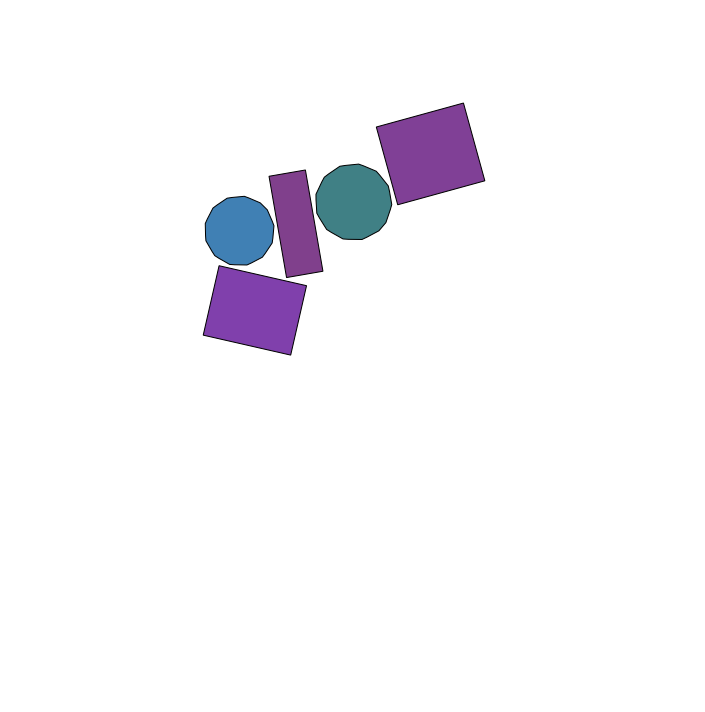

In [3]:
print len(scenes_dataset_yaml)

plt.figure().set_size_inches(10, 10)
side_width = 1
for k in range(side_width):
    for l in range(side_width):
        plt.subplot(side_width, side_width, k*side_width+l+1)
        scene = scenes_dataset_yaml[k*side_width+l+1]
        print(scene)
        dataset_utils.DrawYamlEnvironmentPlanar(scene, "planar_tabletop", ax=plt.gca())
        x = np.vstack(scene["obj_%04d" % k]["pose"][0:2] for k in range(scene["n_objects"]))
        plt.gca().set_title("")
        plt.tight_layout()

Train batch size:  2987
Test batch size:  746


(0.0, 0.2)

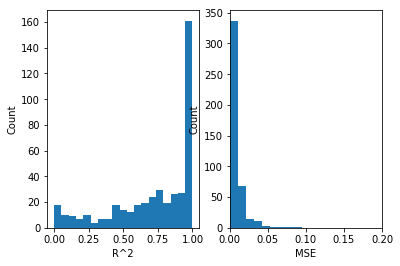

In [4]:
scenes_dataset = dataset_utils.ScenesDatasetVectorized(
    DATA_DIR_TRAIN, max_num_objects=5,
    base_environment_type="planar_tabletop")
data = scenes_dataset.get_full_dataset()

scenes_dataset_test = dataset_utils.ScenesDatasetVectorized(
    DATA_DIR_TEST,max_num_objects=5,
    base_environment_type="planar_tabletop")
data_test = scenes_dataset_test.get_full_dataset()

print "Train batch size: ", data.batch_size
print "Test batch size: ", data_test.batch_size


# Measure colinearity by doing a linear fit and reporting the error
import scipy.stats
rsquares = []
mses = []
for scene in data_test.convert_to_yaml():
    if (scene["n_objects"] > 2):
        x = np.vstack(scene["obj_%04d" % k]["pose"][0:2] for k in range(scene["n_objects"]))
        slope, intercept, rvalue, pvalue, stderr = scipy.stats.linregress(x[:, 0], x[:, 1])
        rsquares.append(rvalue**2.)
        mses.append(np.mean(np.square(x[:, 1] - (intercept + slope*x[:, 0]))))
plt.figure()
plt.subplot(1, 2, 1)
plt.hist(rsquares, bins=np.linspace(0.0, 1.0, 20))
plt.ylabel("Count")
plt.xlabel("R^2")
plt.subplot(1, 2, 2)
plt.hist(mses, bins=np.linspace(0.0, 0.2, 20))
plt.ylabel("Count")
plt.xlabel("MSE")
plt.xlim(0.0, 0.2)

In [15]:
pyro.enable_validation(True)

log_dir = "/home/gizatt/projects/scene_generation/models/runs/pmomc2/planar_tabletop_lines/realproj_context" + datetime.datetime.now().strftime(
    "%Y-%m-%d-%H-%m-%s")
writer = SummaryWriter(log_dir)
def write_np_array(writer, name, x, i):
    for yi, y in enumerate(x):
        writer.add_scalar(name + "/%d" % yi, y, i)

pyro.clear_param_store()
model = MultiObjectMultiClassModelWithContext(scenes_dataset, use_projection=True)
pyro.get_param_store().save("planar_multi_object_multi_class_2_with_context_lines_untrained.pyro")
#guide = AutoDelta(poutine.block(model.model, hide=["obs"]))

scheduler = pyro.optim.StepLR(
    {"optimizer": torch.optim.Adam,
     "optim_args": {'lr': 0.001, 'betas': [0.9, 0.99], 'weight_decay': 1E-4},
      "step_size": 300,
      "gamma": 0.1
    })
elbo = Trace_ELBO(max_plate_nesting=1)
svi = SVI(model.model, model.guide, scheduler, loss=elbo)
losses = []
losses_test = []
best_on_test_loss = 0
best_test_loss = np.infty
cycles_since_improvement = 0

snapshots = {}
for i in range(3000):
    start_time = time.time()
    loss = svi.step(data, subsample_size=100) / data.batch_size
    losses.append(loss)
    writer.add_scalar('loss', loss, i)

    loss_test = svi.evaluate_loss(data_test, subsample_size=50) / data_test.batch_size
    losses_test.append(loss_test)
    writer.add_scalar('loss_test', loss_test, i)

    end_time = time.time()
    if (i % 1 == 0):
        print("Iter: %d, Loss: %f, Loss_test: %f, Best test loss: %f, Time per step: %f" % (
            i, loss, loss_test, best_test_loss, end_time - start_time))

    if loss_test < best_test_loss:
        pyro.get_param_store().save("best_on_test_save.pyro")
        best_test_loss = loss_test
        cycles_since_improvement = 0
    else:
        cycles_since_improvement += 1
        if loss_test > 100000 or (i > 300 and cycles_since_improvement > 300):
            print("Terminating early due to rising test loss")
            break

print "Done"

Iter: 0, Loss: 50.760236, Loss_test: 50.578329, Best test loss: inf, Time per step: 3.765682
Iter: 1, Loss: 57.274182, Loss_test: 50.615140, Best test loss: 50.578329, Time per step: 4.063051
Iter: 2, Loss: 56.615832, Loss_test: 55.673682, Best test loss: 50.578329, Time per step: 3.936508
Iter: 3, Loss: 52.314908, Loss_test: 50.183615, Best test loss: 50.578329, Time per step: 4.239260
Iter: 4, Loss: 54.020611, Loss_test: 43.973237, Best test loss: 50.183615, Time per step: 4.004229
Iter: 5, Loss: 43.936643, Loss_test: 49.362726, Best test loss: 43.973237, Time per step: 3.794702
Iter: 6, Loss: 45.787783, Loss_test: 48.455361, Best test loss: 43.973237, Time per step: 4.088467
Iter: 7, Loss: 43.016068, Loss_test: 35.784444, Best test loss: 43.973237, Time per step: 3.796510
Iter: 8, Loss: 42.994422, Loss_test: 48.884902, Best test loss: 35.784444, Time per step: 3.961971
Iter: 9, Loss: 40.786679, Loss_test: 42.189458, Best test loss: 35.784444, Time per step: 4.088128
Iter: 10, Loss: 

Iter: 83, Loss: 10.367719, Loss_test: 8.758582, Best test loss: 8.982699, Time per step: 3.533516
Iter: 84, Loss: 9.451489, Loss_test: 23.788484, Best test loss: 8.758582, Time per step: 3.991222
Iter: 85, Loss: 10.136922, Loss_test: 10.236637, Best test loss: 8.758582, Time per step: 4.092655
Iter: 86, Loss: 11.930544, Loss_test: 12.857257, Best test loss: 8.758582, Time per step: 4.023076
Iter: 87, Loss: 9.230450, Loss_test: 10.923873, Best test loss: 8.758582, Time per step: 4.006310
Iter: 88, Loss: 9.672903, Loss_test: 14.169619, Best test loss: 8.758582, Time per step: 4.003470
Iter: 89, Loss: 10.279916, Loss_test: 10.094562, Best test loss: 8.758582, Time per step: 4.715816
Iter: 90, Loss: 8.593902, Loss_test: 8.442533, Best test loss: 8.758582, Time per step: 3.700679
Iter: 91, Loss: 11.156284, Loss_test: 18.196605, Best test loss: 8.442533, Time per step: 4.258047
Iter: 92, Loss: 11.991775, Loss_test: 8.930999, Best test loss: 8.442533, Time per step: 4.005542
Iter: 93, Loss: 8

Iter: 167, Loss: 11.418968, Loss_test: 8.475215, Best test loss: 4.438784, Time per step: 4.498068
Iter: 168, Loss: 7.673103, Loss_test: 10.103768, Best test loss: 4.438784, Time per step: 4.520201
Iter: 169, Loss: 5.800052, Loss_test: 4.446600, Best test loss: 4.438784, Time per step: 4.371791
Iter: 170, Loss: 4.279627, Loss_test: 4.314552, Best test loss: 4.438784, Time per step: 4.332217
Iter: 171, Loss: 4.262787, Loss_test: 4.726965, Best test loss: 4.314552, Time per step: 4.711640
Iter: 172, Loss: 5.143891, Loss_test: 13.227221, Best test loss: 4.314552, Time per step: 4.669986
Iter: 173, Loss: 3.938677, Loss_test: 22.007828, Best test loss: 4.314552, Time per step: 4.116797
Iter: 174, Loss: 4.684805, Loss_test: 18.725689, Best test loss: 4.314552, Time per step: 4.751268
Iter: 175, Loss: 6.792714, Loss_test: 4.836816, Best test loss: 4.314552, Time per step: 4.361490
Iter: 176, Loss: 9.527286, Loss_test: 4.063511, Best test loss: 4.314552, Time per step: 4.470332
Iter: 177, Loss

Iter: 251, Loss: 3.498553, Loss_test: 9.657695, Best test loss: 3.012824, Time per step: 4.162044
Iter: 252, Loss: 10.570343, Loss_test: 5.213869, Best test loss: 3.012824, Time per step: 4.803732
Iter: 253, Loss: 9.228006, Loss_test: 3.863828, Best test loss: 3.012824, Time per step: 3.814159
Iter: 254, Loss: 3.906984, Loss_test: 11.523885, Best test loss: 3.012824, Time per step: 4.401276
Iter: 255, Loss: 4.041708, Loss_test: 4.722663, Best test loss: 3.012824, Time per step: 4.233569
Iter: 256, Loss: 5.940047, Loss_test: 3.927607, Best test loss: 3.012824, Time per step: 4.292800
Iter: 257, Loss: 4.347113, Loss_test: 6.834033, Best test loss: 3.012824, Time per step: 4.322559
Iter: 258, Loss: 7.100143, Loss_test: 7.258051, Best test loss: 3.012824, Time per step: 4.563507
Iter: 259, Loss: 4.574647, Loss_test: 7.706052, Best test loss: 3.012824, Time per step: 4.309698
Iter: 260, Loss: 4.240948, Loss_test: 4.567462, Best test loss: 3.012824, Time per step: 4.596109
Iter: 261, Loss: 3

Iter: 335, Loss: 4.675119, Loss_test: 16.691896, Best test loss: 2.531077, Time per step: 4.782002
Iter: 336, Loss: 6.716811, Loss_test: 4.013564, Best test loss: 2.531077, Time per step: 4.821586
Iter: 337, Loss: 3.452061, Loss_test: 4.316023, Best test loss: 2.531077, Time per step: 4.385569
Iter: 338, Loss: 4.278995, Loss_test: 12.864136, Best test loss: 2.531077, Time per step: 4.288987
Iter: 339, Loss: 3.928919, Loss_test: 4.200142, Best test loss: 2.531077, Time per step: 4.539145
Iter: 340, Loss: 3.295404, Loss_test: 3.670612, Best test loss: 2.531077, Time per step: 4.708216
Iter: 341, Loss: 3.611492, Loss_test: 3.911787, Best test loss: 2.531077, Time per step: 4.707443
Iter: 342, Loss: 4.219393, Loss_test: 9.005190, Best test loss: 2.531077, Time per step: 4.646568
Iter: 343, Loss: 3.348099, Loss_test: 11.123840, Best test loss: 2.531077, Time per step: 4.310801
Iter: 344, Loss: 3.397342, Loss_test: 9.799420, Best test loss: 2.531077, Time per step: 4.039925
Iter: 345, Loss: 

Iter: 419, Loss: 3.177982, Loss_test: 3.663245, Best test loss: 2.531077, Time per step: 3.433418
Iter: 420, Loss: 3.190238, Loss_test: 3.835149, Best test loss: 2.531077, Time per step: 4.296100
Iter: 421, Loss: 3.289096, Loss_test: 3.519578, Best test loss: 2.531077, Time per step: 3.676192
Iter: 422, Loss: 4.752883, Loss_test: 3.259807, Best test loss: 2.531077, Time per step: 4.157874
Iter: 423, Loss: 4.288601, Loss_test: 4.123908, Best test loss: 2.531077, Time per step: 4.778030
Iter: 424, Loss: 3.868638, Loss_test: 3.099052, Best test loss: 2.531077, Time per step: 4.575096
Iter: 425, Loss: 3.332683, Loss_test: 3.195379, Best test loss: 2.531077, Time per step: 3.916733
Iter: 426, Loss: 3.740669, Loss_test: 2.996843, Best test loss: 2.531077, Time per step: 4.236170
Iter: 427, Loss: 3.653648, Loss_test: 4.871425, Best test loss: 2.531077, Time per step: 4.176974
Iter: 428, Loss: 6.091867, Loss_test: 3.065225, Best test loss: 2.531077, Time per step: 4.861980
Iter: 429, Loss: 4.0

KeyboardInterrupt: 

In [5]:
# Load model
pyro.clear_param_store()
model = MultiObjectMultiClassModelWithContext(scenes_dataset, use_projection=True)
pyro.get_param_store().load("best_on_test_save.pyro")

optim = pyro.optim.Adam({'lr': 0.01, 'betas': [0.9, 0.99]})
elbo = Trace_ELBO(max_plate_nesting=1)
svi = SVI(model.model, model.guide, optim, loss=elbo)
print("Loaded model evaluated on all of test: ",
      svi.evaluate_loss(data_test) / data_test.batch_size)

/home/gizatt/miniconda3/envs/py27_pyro/lib/python2.7/site-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


('Loaded model evaluated on all of test: ', 5.180514829088472)


In [ ]:
cycles_since_improvement = 0
scheduler = pyro.optim.StepLR(
    {"optimizer": torch.optim.Adam,
     "optim_args": {'lr': 0.00001, 'betas': [0.9, 0.99]},
      "step_size": 200,
      "gamma": 0.1
    })
elbo = Trace_ELBO(max_plate_nesting=1)
svi = SVI(model.model, model.guide, scheduler, loss=elbo)

losses = []
losses_test = []
best_on_test_loss = 0
best_test_loss = np.infty
cycles_since_improvement = 0

for i in range(2000):
    start_time = time.time()
    loss = svi.step(data, subsample_size=2000) / data.batch_size
    losses.append(loss)
#    writer.add_scalar('loss', loss, i)

    loss_test = svi.evaluate_loss(data_test, subsample_size=500) / data_test.batch_size
    losses_test.append(loss_test)
#    writer.add_scalar('loss_test', loss_test, i)

    if loss_test < best_test_loss:
        pyro.get_param_store().save("best_on_test_save.pyro")
        best_test_loss = loss_test
        cycles_since_improvement = 0
    else:
        cycles_since_improvement += 1
        if cycles_since_improvement > 200:
            print("Terminating early due to rising test loss")
            break

    #for p in interesting_params:
    #    write_np_array(writer, p, snapshots[p][-1], i)
    end_time = time.time()
    if (i % 1 == 0):
        print("Iter: %d, Loss: %f, Loss_test: %f, Best test loss: %f, Time per step: %f" % (
            i, loss, loss_test, best_test_loss, end_time - start_time))

In [6]:
plt.figure().set_size_inches(12, 3)
offset = min(np.min(losses), np.min(losses_test))
plt.plot(losses - offset + 1., label="train")
plt.plot(losses_test - offset + 1., label="test")
plt.semilogy()
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss (ELBO)")
plt.title("Loses: final [%f train][%f test][%f best test]" % (np.mean(losses[-20:]), np.mean(losses_test[-20:]), best_test_loss))
#print("Model evaluated on all of test: ",
#      svi.evaluate_loss(data_test) / data_test.batch_size)

NameError: name 'losses' is not defined

<Figure size 864x216 with 0 Axes>

In [ ]:
# Save model
pre_param_settings = {}
for name in pyro.get_param_store().get_all_param_names():
    pre_param_settings[name] = pyro.param(name).clone()

pyro.get_param_store().save("planar_multi_object_multi_class_2_simple_lines_with_projection_no_flows.pyro")
#pyro.get_param_store().save("planar_multi_object_multi_class_2_simple_stacks_with_projection_constraints.pyro")

In [ ]:
# Load model
pyro.clear_param_store()
model = MultiObjectMultiClassModelWithContext(scenes_dataset, use_projection=True)
pyro.get_param_store().load("planar_multi_object_multi_class_2_simple_lines_with_projection_hugenets.pyro")

optim = pyro.optim.Adam({'lr': 0.01, 'betas': [0.9, 0.99]})
elbo = Trace_ELBO(max_plate_nesting=1)
svi = SVI(model.model, model.guide, optim, loss=elbo)
print("Loaded model evaluated on all of test: ",
      svi.evaluate_loss(data_test, subsample_size=500) / data_test.batch_size)

print(model.class_flows[1][4].arn)
pyro.param("class_1_flow_4$$$arn.layers.0.bias")

In [ ]:
# Convert that data back to a YAML environment, which is easier to
# handle.
for i in range(10):
    scene_with_most_objects = None
    for k in range(1):
        generated_data, generated_encodings, generated_contexts = model.model()
        scene_yaml = scenes_dataset.convert_vectorized_environment_to_yaml(
            generated_data)
        if scene_with_most_objects is None or scene_yaml[0]["n_objects"] > scene_with_most_objects["n_objects"]:
            scene_with_most_objects = scene_yaml[0]

    print scene_with_most_objects
    dataset_utils.DrawYamlEnvironment(scene_with_most_objects, "planar_tabletop")
    time.sleep(1.0)

/home/gizatt/miniconda3/envs/py27_pyro/lib/python2.7/site-packages/scipy/stats/_stats_mstats_common.py:116: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/home/gizatt/miniconda3/envs/py27_pyro/lib/python2.7/site-packages/scipy/stats/_stats_mstats_common.py:126: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/home/gizatt/miniconda3/envs/py27_pyro/lib/python2.7/site-packages/scipy/stats/_stats_mstats_common.py:128: RuntimeWarning: invalid value encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


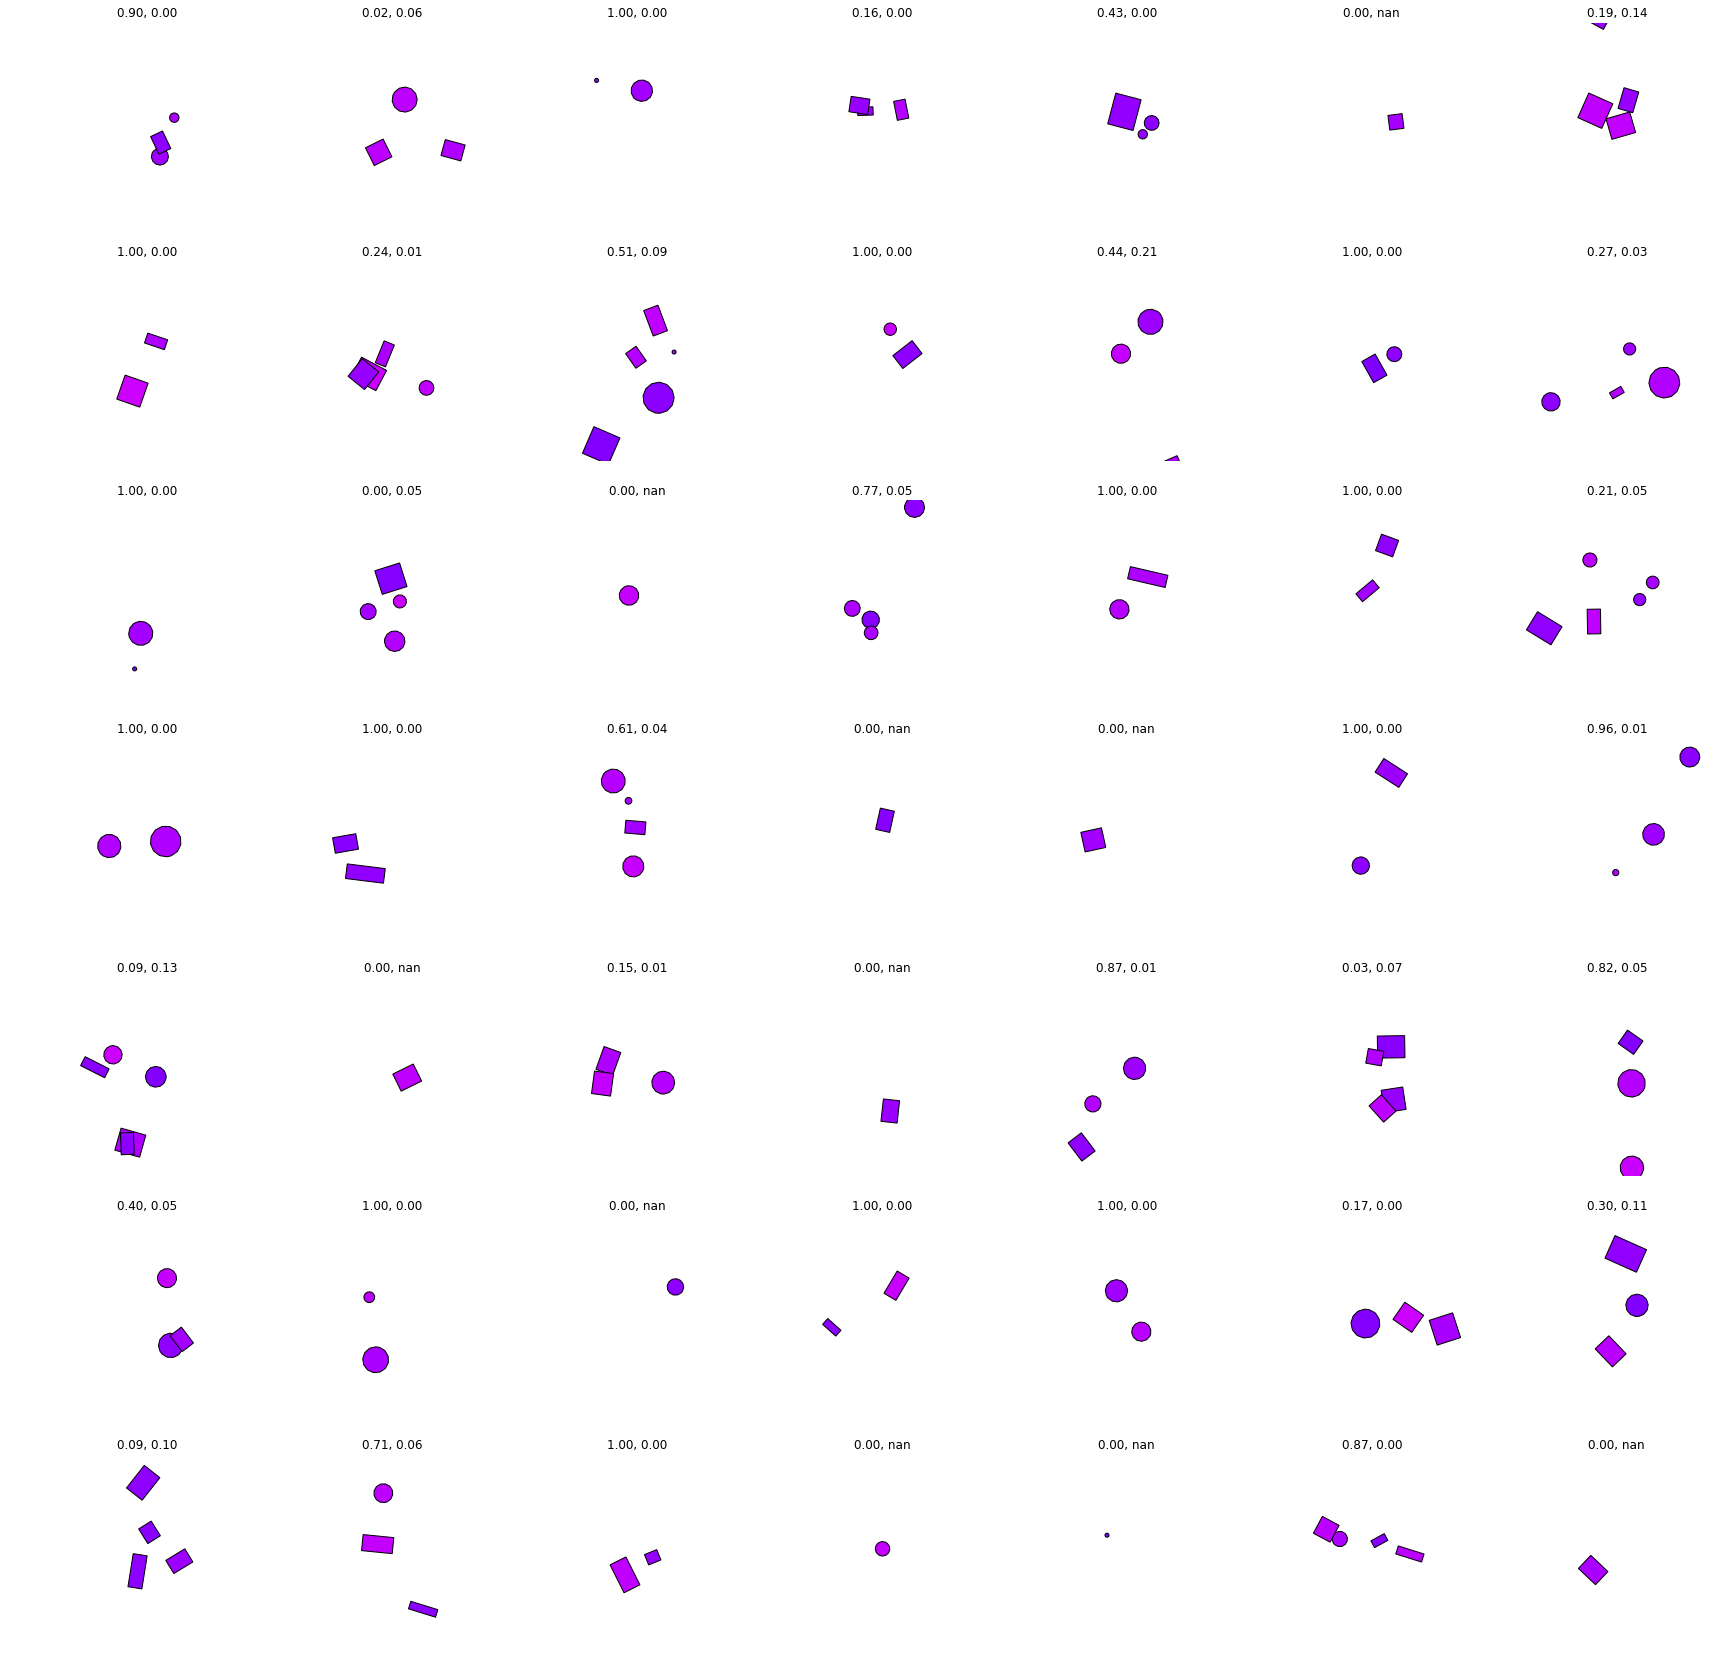

In [6]:
# Convert that data back to a YAML environment, which is easier to
# handle.
import scipy.stats
side_width = 7
generated_data, generated_encodings, generated_contexts = model.model()
scene_yaml = scenes_dataset.convert_vectorized_environment_to_yaml(
    generated_data)
plt.figure().set_size_inches(30, 30)
for k in range(side_width):
    for l in range(side_width):
        plt.subplot(side_width, side_width, k*side_width+l+1)
        scene = scene_yaml[k*side_width+l+1]
        dataset_utils.DrawYamlEnvironmentPlanar(scene, "planar_tabletop", ax=plt.gca())
        x = np.vstack(scene["obj_%04d" % k]["pose"][0:2] for k in range(scene["n_objects"]))
        slope, intercept, rvalue, pvalue, stderr = scipy.stats.linregress(x[:, 0], x[:, 1])
        avg_err = np.mean(np.square(x[:, 1] - (intercept + slope*x[:, 0])))
        plt.gca().set_title("%2.2f, %2.2f" % (rvalue**2, avg_err))

[4, 2, 3, 4, 5, 3, 3, 4, 4, 4, 2, 3, 1, 2, 1, 2, 1, 1, 1, 1, 1, 3, 2, 2, 5, 1, 3, 2, 4, 5, 5, 4, 3, 4, 5, 5, 2, 4, 1, 1, 3, 1, 5, 3, 1, 2, 2, 3, 4, 1, 2, 1, 2, 3, 2, 4, 3, 4, 1, 1, 2, 1, 3, 1, 2, 5, 4, 5, 3, 3, 5, 5, 3, 5, 2, 3, 4, 2, 4, 4, 2, 3, 2, 3, 2, 4, 3, 3, 2, 2, 2, 4, 5, 3, 4, 1, 5, 4, 1, 4, 1, 3, 1, 2, 1, 4, 2, 2, 1, 1, 3, 1, 2, 3, 5, 1, 4, 3, 1, 3, 4, 3, 2, 4, 1, 1, 2, 1, 1, 4, 2, 4, 2, 1, 4, 3, 3, 3, 5, 2, 2, 2, 3, 2, 1, 4, 5, 4, 3, 1, 1, 4, 5, 4, 5, 1, 2, 5, 5, 2, 2, 4, 2, 4, 2, 4, 2, 4, 3, 5, 3, 3, 3, 5, 1, 2, 1, 5, 4, 4, 4, 1, 1, 4, 3, 4, 4, 4, 1, 5, 4, 3, 4, 4, 4, 3, 4, 2, 1, 5, 4, 3, 1, 5, 2, 3, 2, 3, 3, 1, 3, 4, 5, 3, 5, 4, 1, 2, 1, 5, 4, 4, 3, 3, 4, 2, 3, 1, 1, 3, 1, 5, 4, 3, 3, 4, 5, 2, 3, 5, 2, 5, 3, 2, 4, 4, 5, 3, 4, 4, 2, 1, 4, 2, 5, 2, 2, 4, 1, 1, 5, 1, 5, 2, 4, 3, 3, 4, 3, 4, 1, 3, 5, 2, 2, 1, 3, 4, 4, 2, 1, 2, 3, 4, 1, 1, 1, 2, 2, 4, 4, 3, 2, 3, 4, 2, 3, 4, 4, 1, 2, 1, 3, 2, 2, 5, 2, 4, 4, 2, 4, 3, 1, 4, 3, 2, 1, 5, 3, 5, 1, 1, 4, 5, 1, 1, 1, 2, 1, 4, 2, 3, 4, 

Text(0,0.5,'Count')

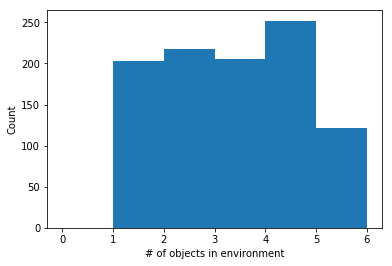

In [7]:
# Convert that data back to a YAML environment, which is easier to
# handle.
generated_n_objs = []
for i in range(20):
    generated_data, generated_encodings, generated_contexts = model.model()
    scene_yaml = scenes_dataset.convert_vectorized_environment_to_yaml(
            generated_data)
    [generated_n_objs.append(scene["n_objects"]) for scene in scene_yaml]
print generated_n_objs
plt.hist(generated_n_objs, bins=range(7))
plt.xlabel("# of objects in environment")
plt.ylabel("Count")

In [8]:
# Assume projection has been done for this trained model and saved to these files...

def generate_params_by_object_class(scenes_dataset_yaml):
    params_by_object_class = {}
    for env_i in range(len(scenes_dataset_yaml)):
        env = scenes_dataset_yaml[env_i]
        for obj_i in range(env["n_objects"]):
            obj_yaml = env["obj_%04d" % obj_i]
            class_name = obj_yaml["class"]
            if class_name not in params_by_object_class.keys():
                params_by_object_class[class_name] = []
            params_by_object_class[class_name].append(obj_yaml["pose"] + obj_yaml["params"])
    return params_by_object_class  

# Generate some examples
scene_yaml = []
for k in range(20):
    generated_data, generated_encodings, generated_contexts = model.model()
    scene_yaml += scenes_dataset.convert_vectorized_environment_to_yaml(generated_data)
params_by_object_class_nonpen = generate_params_by_object_class(scene_yaml)

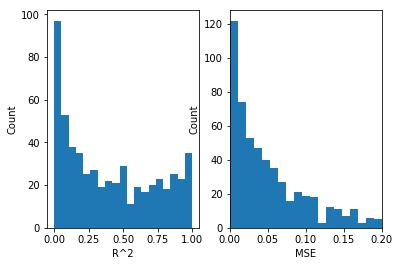

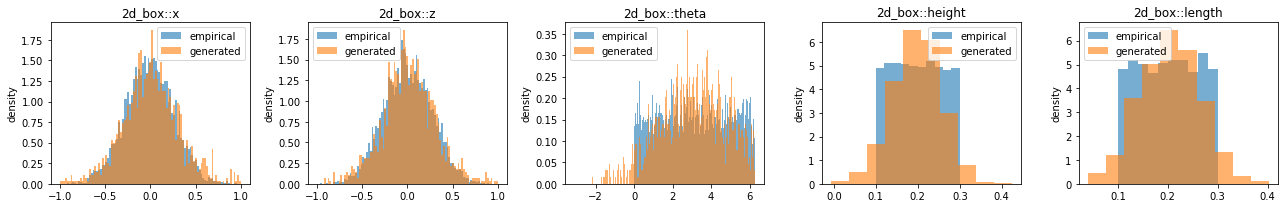

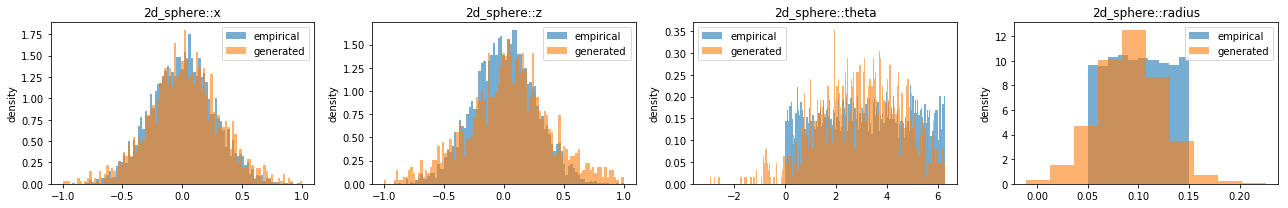

In [9]:
# Measure colinearity by doing a linear fit and reporting the error
import scipy.stats
rsquares = []
mses = []
for scene in scene_yaml:
    if (scene["n_objects"] > 2):
        x = np.vstack(scene["obj_%04d" % k]["pose"][0:2] for k in range(scene["n_objects"]))
        slope, intercept, rvalue, pvalue, stderr = scipy.stats.linregress(x[:, 0], x[:, 1])
        rsquares.append(rvalue**2.)
        mses.append(np.mean(np.square(x[:, 1] - (intercept + slope*x[:, 0]))))
plt.figure()
plt.subplot(1, 2, 1)
plt.hist(rsquares, bins=np.linspace(0.0, 1.0, 20))
plt.ylabel("Count")
plt.xlabel("R^2")
plt.subplot(1, 2, 2)
plt.hist(mses, bins=np.linspace(0.0, 0.2, 20))
plt.ylabel("Count")
plt.xlabel("MSE")
plt.xlim(0.0, 0.2)

for object_name in params_by_object_class.keys():
    object_id = scenes_dataset.class_name_to_id[object_name]
    plt.figure().set_size_inches(18, 3)
    
    param_sets_base = [
        params_by_object_class[object_name],
        params_by_object_class_nonpen[object_name]
    ]
    #params_sets_names = ["empirical", "nonpenetrating", "static"]
    params_sets_names = ["empirical", "generated"]
    
    param_sets = []
    for params in param_sets_base:
        params_stacked = np.stack(params).copy()
        #params_stacked[:, 2] = ((params_stacked[:, 2] + 2 * np.pi) % (2 * np.pi) - np.pi)
        param_sets.append(params_stacked)

    for k in range(param_sets[0].shape[1]):
        if k >= 3:
            param_name = scenes_dataset.params_names_by_class[object_id][k - 3]
        else:
            param_name = ["x", "z", "theta"][k]
        plt.subplot(1, param_sets[0].shape[1], k+1)
        plt.title(object_name + "::" + param_name)
        plt.ylabel("density")
        bins = None
        if k == 0:
            bins = np.linspace(-1., 1., 100)
        elif k == 1:
            bins = np.linspace(-1., 1., 100)
        elif k == 2:
            bins = np.linspace(-np.pi, 2*np.pi, 200)
        for i, params in enumerate(param_sets):
            x_bins = plt.hist(params[:, k], label=params_sets_names[i], density=True, bins=bins, alpha=0.6)[1]
        x_range = np.linspace(x_bins[0], x_bins[-1], 100)
        plt.legend()
        
    plt.tight_layout()

In [ ]:
# EXPORT
for k in range(50):
    generated_data, generated_encodings, generated_contexts = model.model()
    scene_yaml += scenes_dataset.convert_vectorized_environment_to_yaml(generated_data)
    
import yaml
noalias_dumper = yaml.dumper.SafeDumper
noalias_dumper.ignore_aliases = lambda self, data: True

for env in scene_yaml:
    env_name = "env_%d" % int(round(time.time() * 1000))
    with open("generated_tabletop_lines_scenes_without_context_with_projection.yaml", "a") as file:
        yaml.dump({env_name:
                   env}, file, Dumper=noalias_dumper)

In [ ]:
# Probe what the guide is doing by, for a few test data examples,
from copy import deepcopy
subsample_inds = np.random.permutation(data_test.batch_size)
plt.figure().set_size_inches(6, 20)
N_examples = 3
for k in range(N_examples):
    plt.subplot(2, N_examples, k+1)
    data_test_subsample = data_test.subsample([subsample_inds[k]])
    generated_env = deepcopy(data_test_subsample.convert_to_yaml()[0])
    dataset_utils.DrawYamlEnvironmentPlanar(generated_env, "planar_tabletop", ax=plt.gca())
    plt.gca().set_title("BEFORE INV PROJ %d" % k)
    plt.subplot(2, N_examples, N_examples+k+1)
    for object_i in range(generated_env["n_objects"]):
        obj_yaml = generated_env["obj_%04d" % object_i]
        class_i = data_test_subsample.dataset.class_name_to_id[obj_yaml["class"]]
        new_params = model.class_guides[class_i](data_test_subsample.params_by_class[class_i][:, object_i, :])
        obj_yaml["pose"] = new_params[0, :3]
        obj_yaml["params"] = new_params[0, 3:]
    dataset_utils.DrawYamlEnvironmentPlanar(generated_env, "planar_tabletop", ax=plt.gca())
    plt.gca().set_title("AFTER INV PROJ %d" % k)